In [35]:
import numpy as np
import pandas as pd
import re
import krippendorff
from collections import defaultdict, Counter
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Fetching Data

df_mikkel = pd.read_json("annotations_mikkel.json")
df_david = pd.read_json("annotations_david.json")

#Fix of dataframe
def parse_label_string(label_str):
    return re.findall(r"'(.*?)'", label_str)

df_mikkel['original_label'] = df_mikkel['original_label'].apply(parse_label_string)

#Check:
df_mikkel["original_label"].iloc[0][0]

'None'

In [3]:
# Preparing data and setting variables 

num_encoder = {'None': 0,
               'Minimal': 1,
               'Basic': 2,
               'Good': 3,
               'Excellent': 4}

N = len(df_mikkel)
R = 5 #number of ratings

score_data = []

for i in range(len(df_mikkel)):
    labels = [df_mikkel["our_label"].iloc[i]] + [df_david["our_label"].iloc[i]] + df_mikkel["original_label"].iloc[i]
    scores = [num_encoder[label] for label in labels]
    score_data.append(scores) #list of lists

____

## Global aggreement: MSD and Krippendorffs $\alpha$

### MSD

In [4]:

def Mean_Squared_Diff(score_data): # --> list of lists

    SD_list = []

    for scores in score_data:
        c = len(scores)
        #The Squared Difference between unordered distinct pairs for one text:
        SD = (2 / (c * (c - 1))) * sum(
            (scores[j] - scores[k]) ** 2 
            for j in range(c) 
            for k in range(j+1,c))
        SD_list.append(SD)

    return np.mean(SD_list)

MSD = Mean_Squared_Diff(score_data)

MSD

np.float64(1.3060000000000003)

### Krippendorff's $\alpha$

In [5]:
# Alpha calculated with library

def K_alpha(score_data):
    reliability_data = np.array(score_data).T 
    alpha = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement='ordinal')
    return alpha

alpha = K_alpha(score_data)
alpha

np.float64(0.4186097634730207)

In [6]:
#Alpha calculated by hand:

D_o = MSD

# All annotation scores
all_scores = np.asarray(score_data).flatten()


label_counts = Counter(all_scores)  #dict
labels = list(range(R))
n_total = len(all_scores)  # total annotations

# Calculate D_e
De_numerator = 0
for i in range(R):
    for j in range(i + 1, R):
        a = labels[i]
        b = labels[j]
        n_a = label_counts[a]
        n_b = label_counts[b]
        delta = (a - b) ** 2
        De_numerator += n_a * n_b * delta

D_e =  De_numerator * 2 / (n_total * (n_total - 1))

alpha_simplifed = 1 - D_o / D_e
alpha_simplifed

np.float64(0.4111397446833117)

In [7]:
#Testing for equal results
# --> for all distinct ordered pairs and normalized difference

R = 5 #number of ratings

SD_list = []

for scores in score_data[1:]:
    c = len(scores)
    SD = (1 / (c * (c - 1))) * sum(
        ((scores[j] - scores[k]) / (R - 1)) ** 2
        for j in range(c)
        for k in range(c)
        if j != k
    )
    SD_list.append(SD)

D_o = np.mean(SD_list)

# All annotation scores
all_scores = np.asarray(score_data).flatten()


label_counts = Counter(all_scores)  #dict
labels = list(range(R))
n_total = len(all_scores)  # total annotations

# Calculate D_e
De_numerator = 0
for i in range(R):
    for j in range(R):
        a = labels[i]
        b = labels[j]
        if a == b:
            continue
        n_a = label_counts[a]
        n_b = label_counts[b]
        delta = ((a - b) / (R-1)) ** 2
        De_numerator += n_a * n_b * delta

D_e =  De_numerator * 1 / (n_total * (n_total - 1))

alpha_ordered = 1 - D_o / D_e
alpha_ordered

np.float64(0.4051916612962747)

We only see small differences in the output, which might be due to data structures used (lists vs matrices). For simplicity we will use the alpha from the library.

_______
## Comparing annotators

In [74]:
def entropy(score_d):
    H = []
    for scores in score_d:
        total = len(scores)
        counts = Counter(scores)
        probs = [count / total for count in counts.values()]
        h_ = -sum(p * np.log2(p) for p in probs if p > 0)
        H.append(h_)
    return np.mean(H)

def norm_entropy(score_d):
    H = []
    for scores in score_d:
        total = len(scores)
        counts = Counter(scores)
        K = len(counts)
        probs = [count / total for count in counts.values()]
        h_norm = -sum(p * np.log2(p) for p in probs if p > 0) / np.log2(K) if K > 1 else 0.0
        H.append(h_norm)
    return np.mean(H)

In [76]:
n = 2 #number of author annotators

data = {"author": [scores[:n] for scores in score_data],
        "fineweb": [scores[n:] for scores in score_data],
        "all": score_data}

agreement = {}
for name,scores in data.items():
    agreement[name] = (Mean_Squared_Diff(scores), K_alpha(scores), norm_entropy(scores))

agreement

{'author': (np.float64(1.01),
  np.float64(0.5174781163361675),
  np.float64(0.57)),
 'fineweb': (np.float64(1.6066666666666665),
  np.float64(0.3381319866159098),
  np.float64(0.7366967920488796)),
 'all': (np.float64(1.3060000000000003),
  np.float64(0.4186097634730207),
  np.float64(0.8091599283609386))}

___
## Comparing classes
We create pools for each annotation class, including all items where a specific class was annotated at least once.

In [75]:
agreement_pools = {}
for i in range(R):
    pool = [scores for scores in data["all"] if i in scores]
    agreement_pools[i] = (Mean_Squared_Diff(pool), K_alpha(pool), norm_entropy(pool))
    print(pool)

agreement_pools

[[0, 0, 0, 0, 0], [1, 0, 0, 0, 2], [1, 0, 2, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 1, 0], [0, 0, 1, 0, 1], [1, 0, 0, 3, 0], [2, 2, 0, 1, 3], [1, 1, 1, 1, 0], [0, 0, 0, 0, 1], [2, 0, 2, 0, 0], [1, 0, 1, 0, 1], [3, 2, 0, 0, 2], [0, 0, 0, 0, 0], [2, 1, 0, 1, 3], [2, 0, 0, 0, 0], [3, 1, 1, 0, 3], [3, 2, 0, 0, 1], [1, 0, 1, 0, 2], [1, 0, 0, 0, 0], [2, 0, 3, 2, 1], [0, 0, 0, 0, 1], [4, 1, 3, 2, 0], [0, 0, 0, 0, 0], [3, 1, 0, 1, 2], [1, 0, 0, 1, 0], [2, 0, 0, 1, 3], [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 1, 0, 0], [2, 2, 0, 3, 1], [2, 1, 1, 3, 0], [1, 1, 0, 0, 0], [1, 0, 1, 1, 1], [0, 0, 0, 0, 0], [1, 0, 1, 1, 0], [0, 0, 0, 1, 0], [1, 3, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 2, 1, 0, 2], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 1], [1, 1, 1, 0, 1], [1, 1, 0, 0, 1], [1, 1, 1, 0, 0], [2, 1, 0, 0, 1], [1, 0, 1, 0, 2], [0, 1, 2, 0, 0], [1, 1, 1, 2, 0], [0, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 1, 0, 0, 1], [1, 2, 1, 0, 0], [1, 1, 0, 0, 1], [0, 0, 0, 1, 

{0: (np.float64(1.2112676056338025),
  np.float64(0.13410157310854953),
  np.float64(0.7914762251830313)),
 1: (np.float64(1.3975903614457832),
  np.float64(0.27392765471141256),
  np.float64(0.8885241497712741)),
 2: (np.float64(1.9094339622641512),
  np.float64(0.16097805915181174),
  np.float64(0.9232908458797633)),
 3: (np.float64(2.3176470588235296),
  np.float64(0.039857817681598684),
  np.float64(0.9364221335450511)),
 4: (np.float64(2.6181818181818186),
  np.float64(-0.03568711339663011),
  np.float64(0.9293400953820105))}

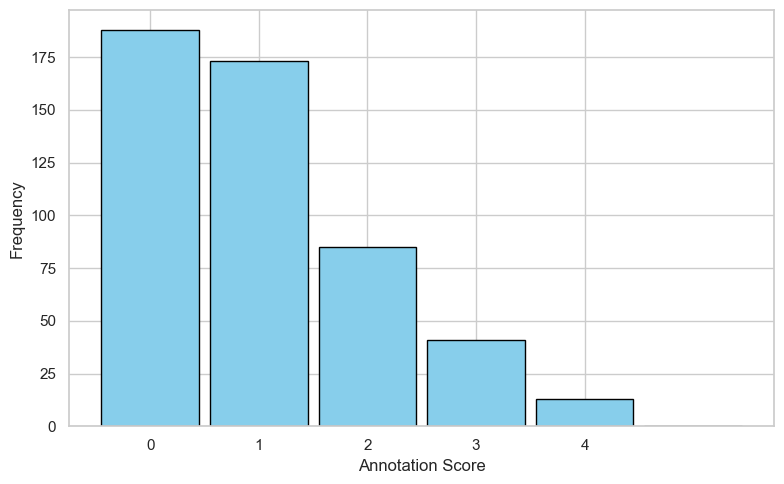

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


bins = [x - 0.5 for x in range(7)]

# Plot
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=bins, edgecolor='black', color='skyblue', rwidth=0.9)

# Customize axes
plt.xticks(range(5)) 
plt.xlabel('Annotation Score')
plt.ylabel('Frequency')

# Clean layout
plt.tight_layout()
plt.show()